In [1]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    
    for _ in range(num_points):
        data_point = []
        positions = set()
        
        # Generate 3 particles with unique positions
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (round(x, 6), round(y, 6))
                
                if position not in positions:
                    positions.add(position)
                    break
            
            # mass = np.random.uniform(0.5, 10) # Commented to make training easier for now
            mass = 1
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 20
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.500425, y = 0.141241, mass = 1.0000, force = [-1.076856e+01, 8.027234e-01]]
  Particle 2: [x = 0.194243, y = 0.077473, mass = 1.0000, force = [1.060530e+01, 4.425487e+00]]
  Particle 3: [x = 0.353129, y = 0.700929, mass = 1.0000, force = [1.632588e-01, -5.228211e+00]]

Data point 2:
  Particle 1: [x = 0.511768, y = 0.875703, mass = 1.0000, force = [2.284040e+00, -1.826062e+01]]
  Particle 2: [x = 0.560730, y = 0.637973, mass = 1.0000, force = [-5.886213e+00, 1.476342e+01]]
  Particle 3: [x = 0.106743, y = 0.294681, mass = 1.0000, force = [3.602172e+00, 3.497195e+00]]

Data point 3:
  Particle 1: [x = 0.896516, y = 0.418723, mass = 1.0000, force = [2.738872e+02, 1.267223e+02]]
  Particle 2: [x = 0.753169, y = 0.189823, mass = 1.0000, force = [1.322521e+01, 1.940148e+01]]
  Particle 3: [x = 0.947204, y = 0.443663, mass = 1.0000, force = [-2.871124e+02, -1.461238e+02]]



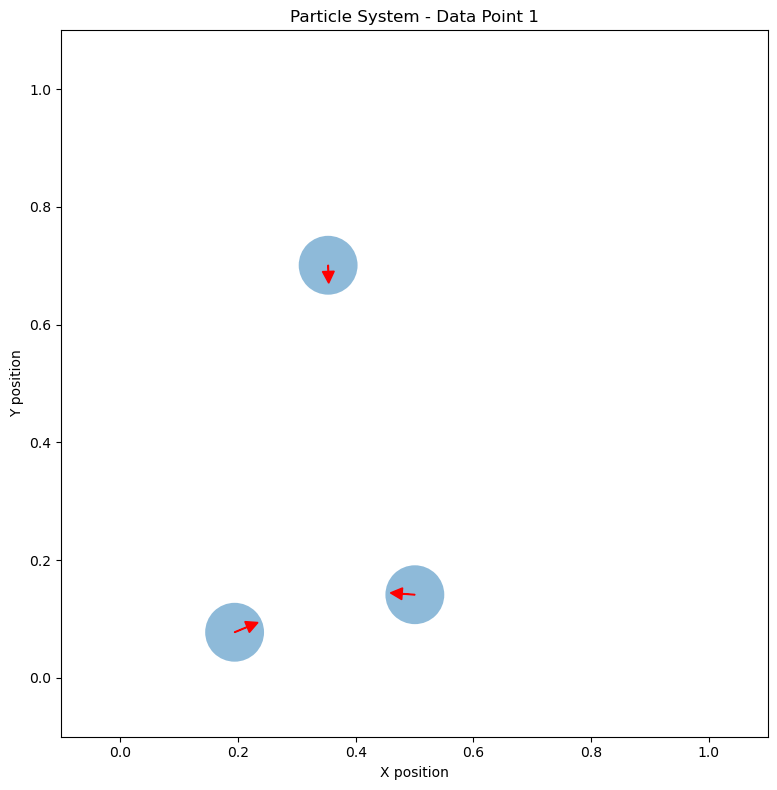

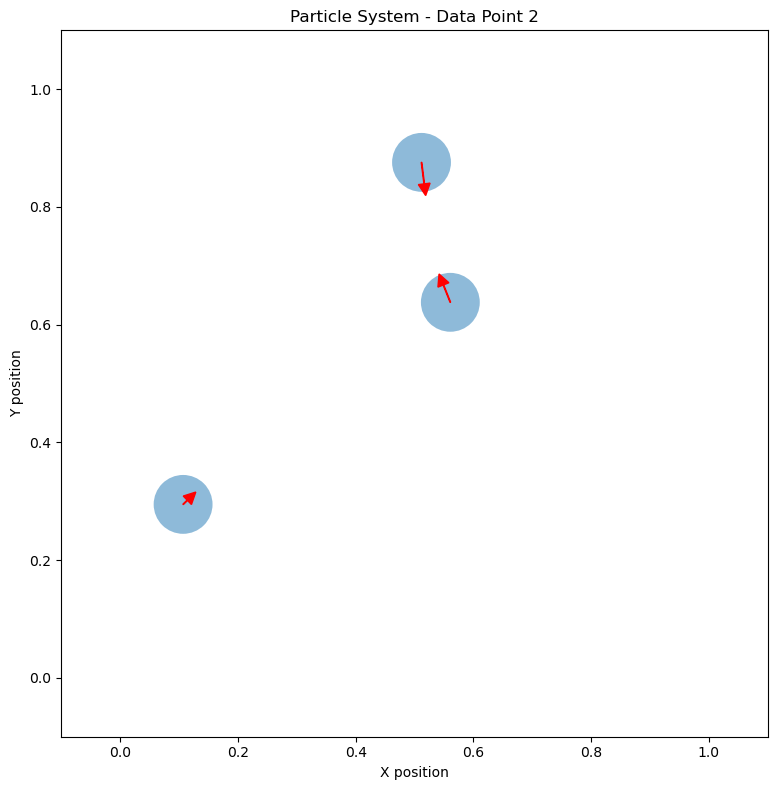

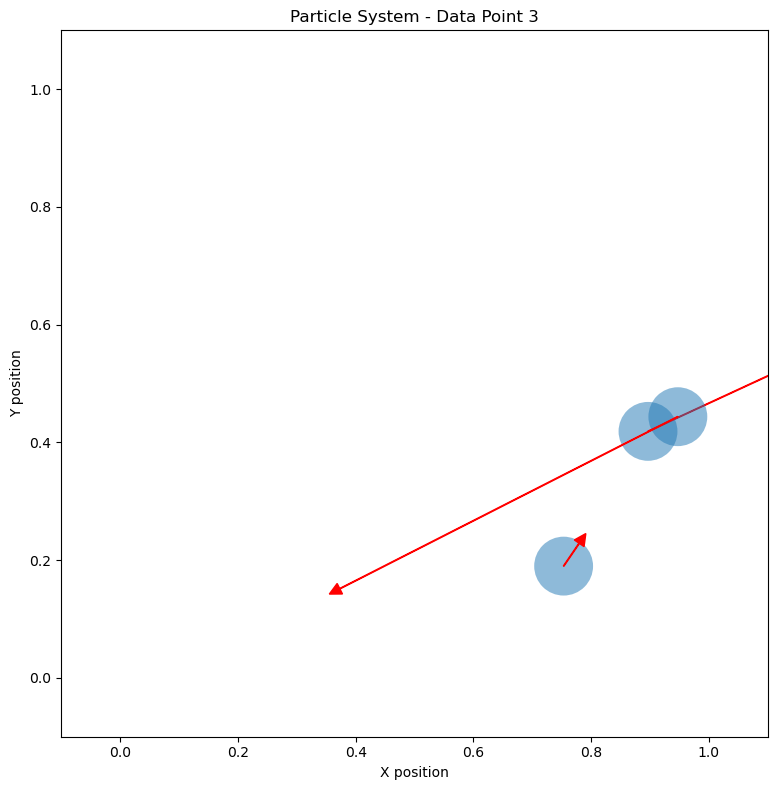

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        size = 50 * (mass / max_mass)  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=size/1000, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.002
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 300),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.ReLU(),
            nn.Linear(300, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        # print("edge index: ", edge_index)
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        # print(tmp)
        out = self.mlp(tmp)
        # print("out: ", out)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        # print("edge attributes: ", edge_attr)
        out = torch.cat([x, edge_attr], dim=1)
        return self.mlp(out)

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.9604, 0.3166, 0.2156],
        [0.0714, 0.0794, 0.3123],
        [0.0395, 0.4501, 0.9712]])
Input:
tensor([[0.9604, 0.3166, 0.2156],
        [0.0714, 0.0794, 0.3123],
        [0.0395, 0.4501, 0.9712]])

Output (forces):
tensor([[-0.0206,  0.0092],
        [ 0.0063, -0.0438],
        [-0.0630, -0.0368]], grad_fn=<AddmmBackward0>)


In [4]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.5004250679681383, 0.1412413925055982, 1, [-10.768561122349078, 0.8027233788068346]], [0.19424273895940714, 0.07747269218956143, 1, [10.60530232084057, 4.425487432121512]], [0.3531292438737452, 0.700928929002434, 1, [0.1632588015085097, -5.228210810928347]]]
[[0.5117684046563149, 0.8757034939190206, 1, [2.2840400962358047, -18.26061687750146]], [0.5607299118021649, 0.6379730777315851, 1, [-5.886212528104682, 14.763422109148507]], [0.10674334568239052, 0.29468081556007764, 1, [3.6021724318688775, 3.497194768352951]]]


tensor([[0.5004, 0.1412, 1.0000],
        [0.1942, 0.0775, 1.0000],
        [0.3531, 0.7009, 1.0000]])
tensor([[0.5118, 0.8757, 1.0000],
        [0.5607, 0.6380, 1.0000],
        [0.1067, 0.2947, 1.0000]])


tensor([[-10.7686,   0.8027],
        [ 10.6053,   4.4255],
        [  0.1633,  -5.2282]])
tensor([[  2.2840, -18.2606],
        [ -5.8862,  14.7634],
        [  3.6022,   3.4972]])


In [5]:
import torch
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 3000  # Define the number of epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    for x, y in zip(x_dataset, y_dataset):
        # Move data to the device
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        output = model(x)
        
        # Compute loss
        loss = criterion(output, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    # Print loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, the model is ready for evaluation or further use
print("Training complete!")

Using device: cuda
Epoch [10/3000], Loss: 3.5220
Epoch [20/3000], Loss: 3.4724
Epoch [30/3000], Loss: 3.4136
Epoch [40/3000], Loss: 3.2793
Epoch [50/3000], Loss: 2.9255
Epoch [60/3000], Loss: 2.5762
Epoch [70/3000], Loss: 2.3500
Epoch [80/3000], Loss: 1.9657
Epoch [90/3000], Loss: 2.1248
Epoch [100/3000], Loss: 2.5007
Epoch [110/3000], Loss: 3.2099
Epoch [120/3000], Loss: 4.7337
Epoch [130/3000], Loss: 8.1201
Epoch [140/3000], Loss: 10.6330
Epoch [150/3000], Loss: 15.3062
Epoch [160/3000], Loss: 22.3688
Epoch [170/3000], Loss: 28.5667
Epoch [180/3000], Loss: 35.9801
Epoch [190/3000], Loss: 45.9732
Epoch [200/3000], Loss: 60.0402
Epoch [210/3000], Loss: 64.8831
Epoch [220/3000], Loss: 77.9618
Epoch [230/3000], Loss: 85.1793
Epoch [240/3000], Loss: 97.8255
Epoch [250/3000], Loss: 108.5545
Epoch [260/3000], Loss: 121.5476
Epoch [270/3000], Loss: 126.7310
Epoch [280/3000], Loss: 143.7941
Epoch [290/3000], Loss: 146.2461
Epoch [300/3000], Loss: 161.2794
Epoch [310/3000], Loss: 164.1857
Epoc

In [6]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.grad.norm())

edge_model.mlp.0.weight tensor(178125.8438, device='cuda:0')
edge_model.mlp.0.bias tensor(86795.5078, device='cuda:0')
edge_model.mlp.2.weight tensor(106245.7812, device='cuda:0')
edge_model.mlp.2.bias tensor(15099.9590, device='cuda:0')
edge_model.mlp.4.weight tensor(17448.9570, device='cuda:0')
edge_model.mlp.4.bias tensor(1312.3256, device='cuda:0')
edge_model.mlp.6.weight tensor(35841.7266, device='cuda:0')
edge_model.mlp.6.bias tensor(554.1132, device='cuda:0')
node_model.mlp.0.weight tensor(11058.4834, device='cuda:0')
node_model.mlp.0.bias tensor(154.4234, device='cuda:0')
node_model.mlp.2.weight tensor(8029.0386, device='cuda:0')
node_model.mlp.2.bias tensor(53.6951, device='cuda:0')
node_model.mlp.4.weight tensor(17887.7715, device='cuda:0')
node_model.mlp.4.bias tensor(24.8411, device='cuda:0')
